Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
import glob

In [5]:
chars = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
train_data = {}
test_data = {}
for char in chars:
    train_data[char]=glob.glob('notMNIST_large/'+ char + '/*.png')
    test_data[char]=glob.glob('notMNIST_small/'+ char + '/*.png')

In [6]:
#show traning data samples
for i in range(5):
    display(Image(train_data['A'][i]))

In [7]:
#display test data samples
for i in range(5):
    display(Image(test_data['A'][i]))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [9]:
from scipy import ndimage

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
  dataset = np.ndarray(
    shape=(max_num_images, image_size, image_size), dtype=np.float32)
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32)
  label_index = 0
  image_index = 0
  for folder in data_folders:
    print(folder)
    for image in os.listdir(folder):
      if image_index >= max_num_images:
        raise Exception('More images than expected: %d >= %d' % (
          image_index, max_num_images))
      image_file = os.path.join(folder, image)
      try:
        image_data = (ndimage.imread(image_file).astype(float) -
                      pixel_depth / 2) / pixel_depth
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data
        labels[image_index] = label_index
        image_index += 1
      except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :]
  labels = labels[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (
        num_images, min_num_images))
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  # uncomment this if enough memory ...
  #print('Standard deviation:', np.std(dataset))
  print('Labels:', labels.shape)
  return dataset, labels
train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)

./notMNIST_large/A


/home/emha/anaconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


Could not read: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file './notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file './notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file './notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
./notMNIST_large/B
Could not read: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file './notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
./notMNIST_large/C
./notMNIST_large/D
Could not read: ./notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file './notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
./notMNIST_large/E
./notMNIST_large/F
./notMNIST_large/G
./

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---
Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [10]:
def plot_two_imgs(img1, img2, img1_title, img2_title):
    fig = plt.figure()
    fig.add_subplot(121)
    image1 = np.reshape(img1, (28, 28)) * 255
    plt.imshow(image1, cmap= plt.cm.binary)
    plt.title(img1_title)
    fig.add_subplot(122)
    adversarial = np.reshape(img2, (28, 28)) * 255
    plt.imshow(adversarial, cmap= plt.cm.binary)
    plt.title(img2_title)
    plt.tight_layout()
    plt.show()

def plot_one_img(img):
    fig = plt.figure()
    fig.add_subplot(121)
    image1 = np.reshape(img, (28, 28)) * 255
    plt.imshow(image1, cmap= plt.cm.binary)

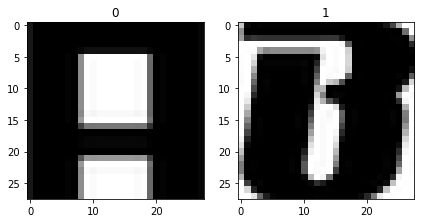

Train  0  =  42326
Validation  0  =  10582


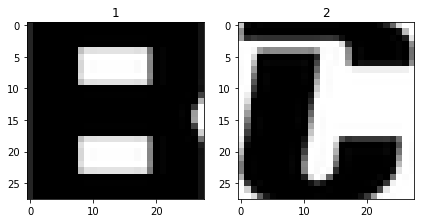

Train  1  =  42326
Validation  1  =  10582


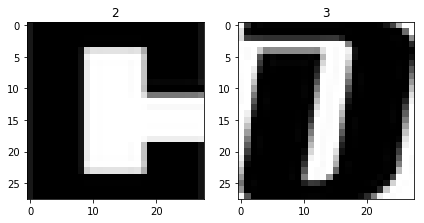

Train  2  =  42326
Validation  2  =  10582


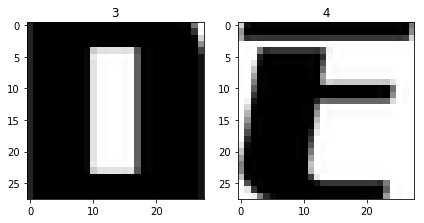

Train  3  =  42326
Validation  3  =  10582


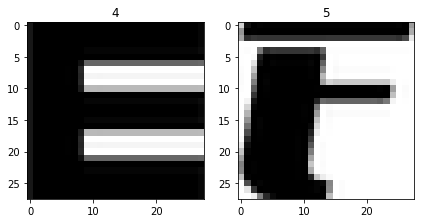

Train  4  =  42326
Validation  4  =  10582


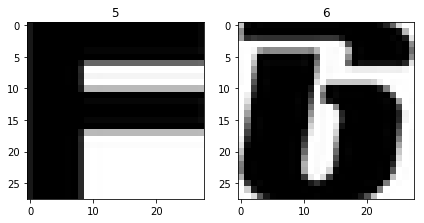

Train  5  =  42326
Validation  5  =  10582


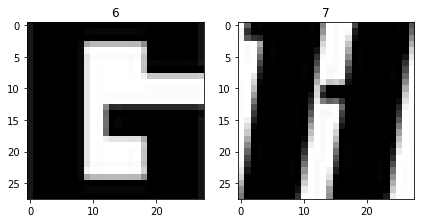

Train  6  =  42326
Validation  6  =  10582


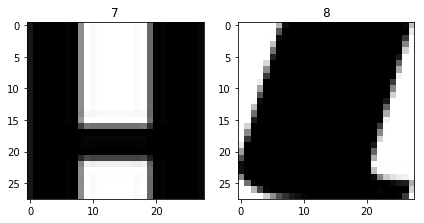

Train  7  =  42326
Validation  7  =  10582


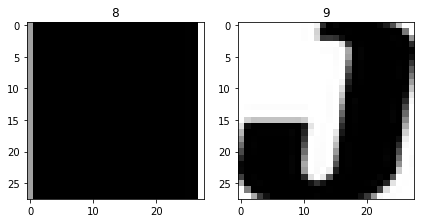

Train  9  =  42326
Validation  9  =  10582


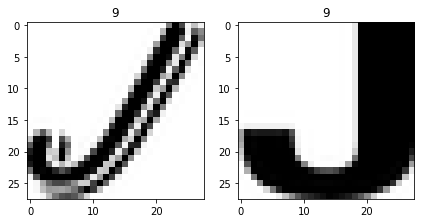

Train  9  =  42326
Validation  9  =  10582
All train dataset [52908, 63494, 74080, 84665, 95251, 105837, 116423, 127009, 137595, 148178]
Selected train set [42326, 42326, 42326, 42326, 42326, 42326, 42326, 42326, 42326, 42326]
Validation set [10582, 10582, 10582, 10582, 10582, 10582, 10582, 10582, 10582, 10582]


In [11]:
#use 20% of the train dataset as validation
curr = 0

train_dataset_size = []
train_set_size = []
valid_set_size = []

max_indv_train_size = 52908
max_indv_valid_size = int(0.2 * len(train_labels) / 10)
max_indv_train_size_new = max_indv_train_size - max_indv_valid_size

valid_count = 0
validation_set = []

validation_dataset = []
validation_labels = []
train_dataset_new = []
train_label_new = []

train_dataset_tmp = []
train_label_tmp = []

flag = False

count_for_last_img = 0

for i in range(len(train_labels)):
    
    if train_labels[i] != int(curr) or count_for_last_img == max_indv_train_size:

        plot_two_imgs(train_dataset[i-1],train_dataset[i],str(curr),str(train_labels[i]))
        
        if curr == 0:
            train_dataset_size.append(i-1)
        else:
            train_dataset_size.append(i-sum(train_set_size))

        curr = train_labels[i]
    
        #Update validation set and new training dataset
        train_dataset_tmp = np.asarray(train_dataset_tmp)
        train_label_tmp = np.asarray(train_label_tmp)

        _valid_dataset = train_dataset_tmp[:max_indv_valid_size, :, :]
        _valid_labels = train_label_tmp[:max_indv_valid_size]
        
        _train_dataset = train_dataset_tmp[max_indv_valid_size : max_indv_valid_size+max_indv_train_size, :, :]
        _train_labels = train_label_tmp[max_indv_valid_size : max_indv_valid_size+max_indv_train_size]
        
        #set the same train set size across all classes
        _train_dataset = _train_dataset[:max_indv_train_size_new, :, :]
        _train_labels = _train_labels[:max_indv_train_size_new]
        
        train_set_size.append(len(_train_labels))
        valid_set_size.append(len(_valid_dataset))
        if curr < 9:
            print("Train ", curr-1, " = ", len(_train_labels))
            print("Validation ", curr-1, " = ", len(_valid_labels))
        elif curr == 9:
            print("Train ", curr, " = ", len(_train_labels))
            print("Validation ", curr, " = ", len(_valid_labels))
            
        validation_dataset.extend(_valid_dataset)
        validation_labels.extend(_valid_labels)
        
        train_dataset_new.extend(_train_dataset)
        train_label_new.extend(_train_labels)

        train_dataset_tmp = []
        train_label_tmp = []
        
        if count_for_last_img == max_indv_train_size:
            break
        
    elif train_labels[i] == int(curr) or (i-sum(train_set_size) <= max_indv_train_size):
        train_dataset_tmp.append(train_dataset[i])
        train_label_tmp.append(train_labels[i])
        if curr == 9:
            count_for_last_img += 1
            
print("All train dataset" ,train_dataset_size)
print("Selected train set", train_set_size)
print("Validation set", valid_set_size)

# Randomized all the dataset

In [12]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

train_dataset_new = np.asarray(train_dataset_new)
train_label_new = np.asarray(train_label_new)
validation_dataset = np.asarray(validation_dataset)
validation_labels = np.asarray(validation_labels)
test_dataset = np.asarray(test_dataset)
test_labels = np.asarray(test_labels)

train_dataset_new, train_label_new = randomize(train_dataset_new, train_label_new)
validation_dataset, validation_labels = randomize(validation_dataset, validation_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

print("Train dataset: ", train_dataset_new.shape, ", label: ", train_label_new.shape)
print("Validation dataset: ", validation_dataset.shape, ", label: ", validation_labels.shape)
print("Test dataset: ", test_dataset.shape, ", label: ", test_labels.shape)

Train dataset:  (423260, 28, 28) , label:  (423260,)
Validation dataset:  (105820, 28, 28) , label:  (105820,)
Test dataset:  (18724, 28, 28) , label:  (18724,)


---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

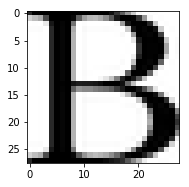

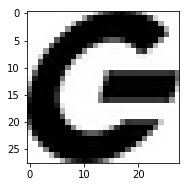

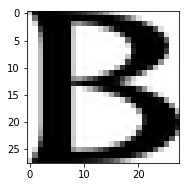

In [13]:
#Check the dataset by plotting
plot_one_img(train_dataset_new[50110])
plot_one_img(validation_dataset[90010])
plot_one_img(test_dataset[10000])

Finally, let's save the data for later reuse:

In [14]:
pickle_file = os.path.join(data_root, 'notMNIST_dataset.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'train_dataset': train_dataset_new,
        'train_labels': train_label_new,
        'valid_dataset': validation_dataset,
        'valid_labels': validation_labels,
        'test_dataset': test_dataset,
        'test_labels': test_labels,
    }
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

In [15]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1720105079


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
# measure how much overlap there is between training, validation and test samples
set_valid_dataset = set([hash(str(x)) for x in validation_dataset])
set_test_dataset = set([hash(str(x)) for x in test_dataset])
set_train_dataset = set([hash(str(x)) for x in train_dataset])

In [ ]:
print ('valid data set: ' + str(len(validation_dataset)) + ' set: ' + str(len(set_valid_dataset)))
print ('test data set: ' + str(len(test_dataset)) + ' set: ' + str(len(set_test_dataset)))
print ('train data set: ' + str(len(train_dataset)) + ' set: ' + str(len(set_train_dataset)))

In [ ]:
overlap_test_valid = set_test_dataset - set_valida_dataset
print ('overlap test valid: ' + str(len(overlap_test_valid)))

overlap_train_valid = set_train_dataset - set_valid_dataset
print ('overlap train valid: ' + str(len(overlap_train_valid)))

overlap_train_test = set_train_dataset - set_test_dataset
print ('overlap train test: ' + str(len(overlap_train_test)))


---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [17]:
#load the pickle file
pickle_in = open("notMNIST_dataset.pickle","rb")
dataset_dict = pickle.load(pickle_in)
train_dataset = dataset_dict.get('train_dataset')
train_labels = dataset_dict.get('train_labels')
valid_dataset = dataset_dict.get('valid_dataset')
valid_labels = dataset_dict.get('valid_labels')
test_dataset = dataset_dict.get('test_dataset')
test_labels = dataset_dict.get('test_labels')

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegressionCV

In [19]:
log_reg = LogisticRegression()

In [20]:
#All train dataset
log_reg = LogisticRegression()
def train(train_dataset, train_labels, sample_size):
    X_train = train_dataset[:sample_size].reshape(sample_size, 784)
    y_train = train_labels[:sample_size]
    %time log_reg.fit(X_train, y_train)
    return log_reg

def test(model, test_dataset, test_labels):
    X_test = test_dataset.reshape(test_dataset.shape[0], 784)
    print(model.score(X_test, test_labels)*100, " %")

In [21]:
#train some models with different training sizes
for size in [50,100,1000,5000]:
    model = train(train_dataset, train_labels, size)
    print ("Validation Accuracy for",size," training size model:")
    test(model, valid_dataset, valid_labels)
    print ("Test Accuracy for",size," training size model:")
    test(model, test_dataset, test_labels)
    print("=========================")

CPU times: user 45.1 ms, sys: 8.18 ms, total: 53.2 ms
Wall time: 72.3 ms
Validation Accuracy for 50  training size model:
59.87998487998488  %
Test Accuracy for 50  training size model:
66.00085451826533  %
CPU times: user 194 ms, sys: 0 ns, total: 194 ms
Wall time: 96.7 ms
Validation Accuracy for 100  training size model:
70.34492534492534  %
Test Accuracy for 100  training size model:
77.2270882290109  %
CPU times: user 2.51 s, sys: 0 ns, total: 2.51 s
Wall time: 2.31 s
Validation Accuracy for 1000  training size model:
76.74352674352674  %
Test Accuracy for 1000  training size model:
84.44776757103183  %
CPU times: user 18.3 s, sys: 6.38 ms, total: 18.3 s
Wall time: 18.1 s
Validation Accuracy for 5000  training size model:
77.82649782649783  %
Test Accuracy for 5000  training size model:
85.41444135868404  %
